In [11]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [12]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
partition = 8
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(partition, partition + 1)
]).collect()

In [13]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [14]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1360    ┆ 0       ┆ 0         ┆ 0.502829   ┆ … ┆ -1.620408  ┆ 0.374767   ┆ -1.049378 ┆ -2.496996 │
│ 1360    ┆ 0       ┆ 1         ┆ 0.351176   ┆ … ┆ -0.027899  ┆ -0.184599  ┆ -0.21643  ┆ -0.182844 │
│ 1360    ┆ 0       ┆ 2         ┆ -0.88357   ┆ … ┆ 0.363652   ┆ 0.236567   ┆ -1.445096 ┆ 0.506134  │
│ 1360    ┆ 0       ┆ 3         ┆ -0.52451   ┆ … ┆ -1.442856  ┆ -0.447208  ┆ 0.857494  ┆ -1.468352 │
│ 1360    ┆ 0       ┆ 4         ┆ -0.62365   ┆ … ┆ -3.025858  ┆ -0.506223  ┆ -0.317776 ┆ -4.478455 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [15]:
train_ds.null_count().transpose(include_header=True).rename({'column_0': 'null_count'}).with_columns(
    pl.col('null_count').truediv(train_ds.shape[0]).mul(100).alias('null_count_pct')
).sort('null_count', descending=True).head(10)

shape: (10, 3)
┌────────────┬────────────┬────────────────┐
│ column     ┆ null_count ┆ null_count_pct │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ u32        ┆ f64            │
╞════════════╪════════════╪════════════════╡
│ feature_39 ┆ 431324     ┆ 7.024793       │
│ feature_42 ┆ 431324     ┆ 7.024793       │
│ feature_50 ┆ 431324     ┆ 7.024793       │
│ feature_53 ┆ 431324     ┆ 7.024793       │
│ feature_08 ┆ 166496     ┆ 2.711651       │
│ feature_15 ┆ 152232     ┆ 2.479339       │
│ feature_41 ┆ 114174     ┆ 1.859504       │
│ feature_44 ┆ 114174     ┆ 1.859504       │
│ feature_52 ┆ 114174     ┆ 1.859504       │
│ feature_55 ┆ 114174     ┆ 1.859504       │
└────────────┴────────────┴────────────────┘

In [16]:
lags = pl.read_parquet(DATA_DIR / 'lags/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [17]:
parts.group_by('part').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ min_date_id ┆ max_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0           ┆ 169         ┆ 1944210     │
│ 1    ┆ 170         ┆ 339         ┆ 2804247     │
│ 2    ┆ 340         ┆ 509         ┆ 3036873     │
│ 3    ┆ 510         ┆ 679         ┆ 4016784     │
│ 4    ┆ 680         ┆ 849         ┆ 5022952     │
│ 5    ┆ 850         ┆ 1019        ┆ 5348200     │
│ 6    ┆ 1020        ┆ 1189        ┆ 6203912     │
│ 7    ┆ 1190        ┆ 1359        ┆ 6335560     │
│ 8    ┆ 1360        ┆ 1529        ┆ 6140024     │
│ 9    ┆ 1530        ┆ 1698        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [18]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
).sort('symbol_id')
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ min_date_id ┆ max_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 0         ┆ 1           ┆ 1698        ┆ 1592      ┆ 1468466     │
│ 1         ┆ 0           ┆ 1698        ┆ 1678      ┆ 1543979     │
│ 2         ┆ 1           ┆ 1698        ┆ 1606      ┆ 1484398     │
│ 3         ┆ 2           ┆ 1698        ┆ 1565      ┆ 1446495     │
│ 4         ┆ 952         ┆ 1698        ┆ 706       ┆ 683408      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

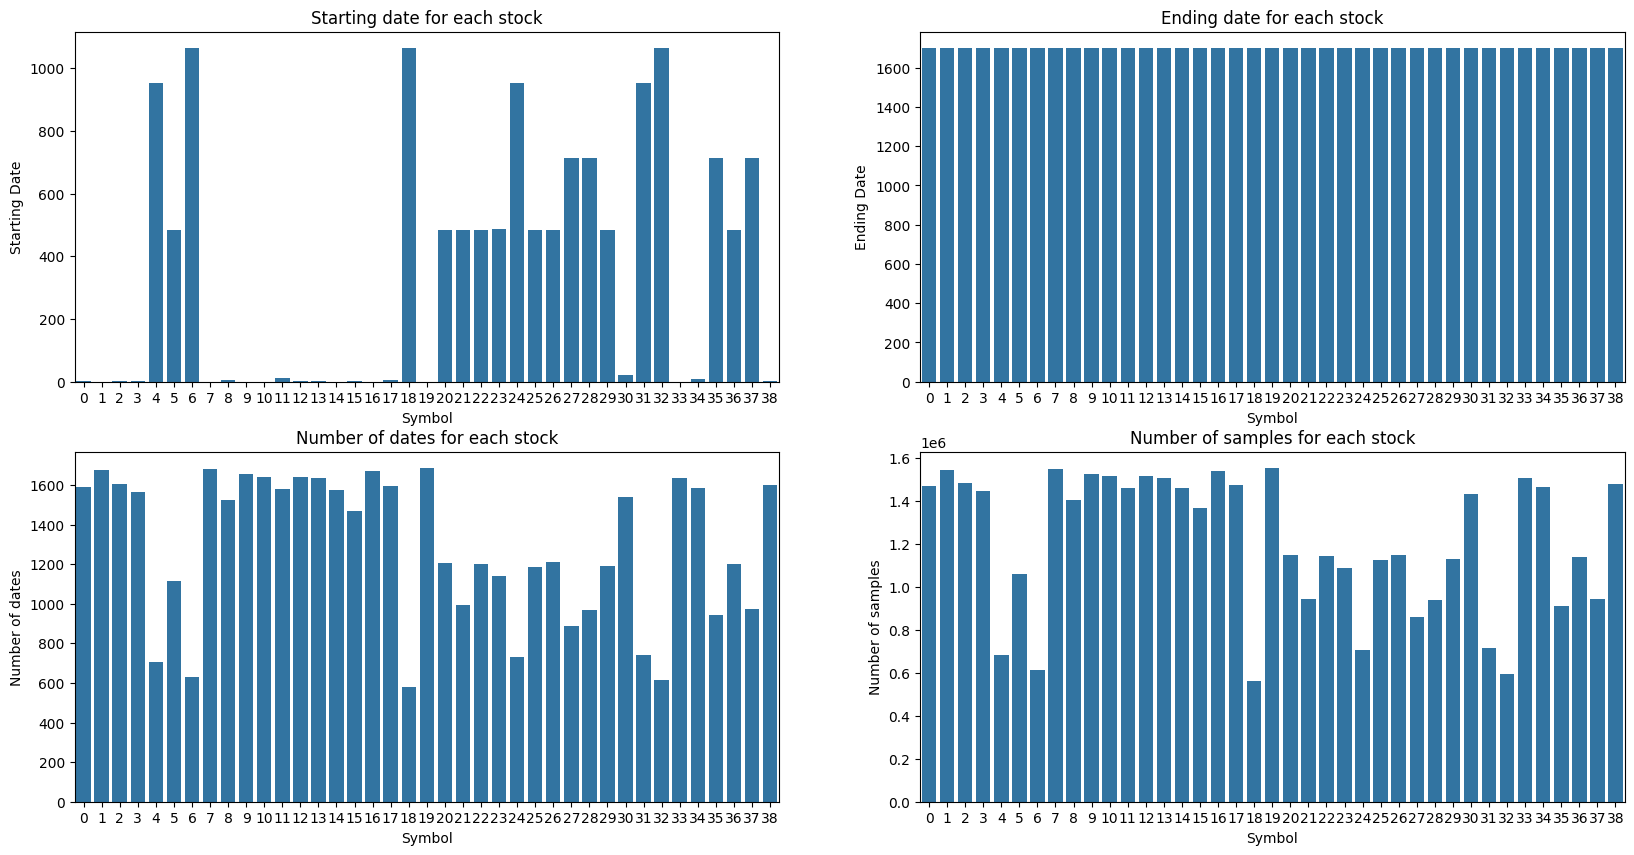

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Basic Correlations

In [20]:
correlations = train_ds.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.044638  ┆ 0.928699  ┆ 0.929983  ┆ … ┆ -0.035514 ┆ -0.001418 ┆ -0.003698 ┆ -0.00072 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3        │
│ 0.044638  ┆ 1.0       ┆ -0.018902 ┆ -0.010965 ┆ … ┆ 0.019705  ┆ -0.015033 ┆ -0.008035 ┆ -0.01349 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 0.928699  ┆ -0.018902 ┆ 1.0       ┆ 0.931905  ┆ … ┆ -0.037027 ┆ 0.001483  ┆ -0.001993 ┆ 0.001891 │
│ 0.929983  ┆ -0.010965 ┆ 0.931905  ┆ 1.0       ┆ … ┆ -0.037473 ┆ -0.000517 ┆ -0.003185 ┆ 0.000386 │
│ 0.000962  ┆ 0.266446  ┆ -0.040959 ┆ -0.014826 ┆ … ┆ -0.017858 ┆ -0.041193 ┆ -0.019477 ┆ -0.04297 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

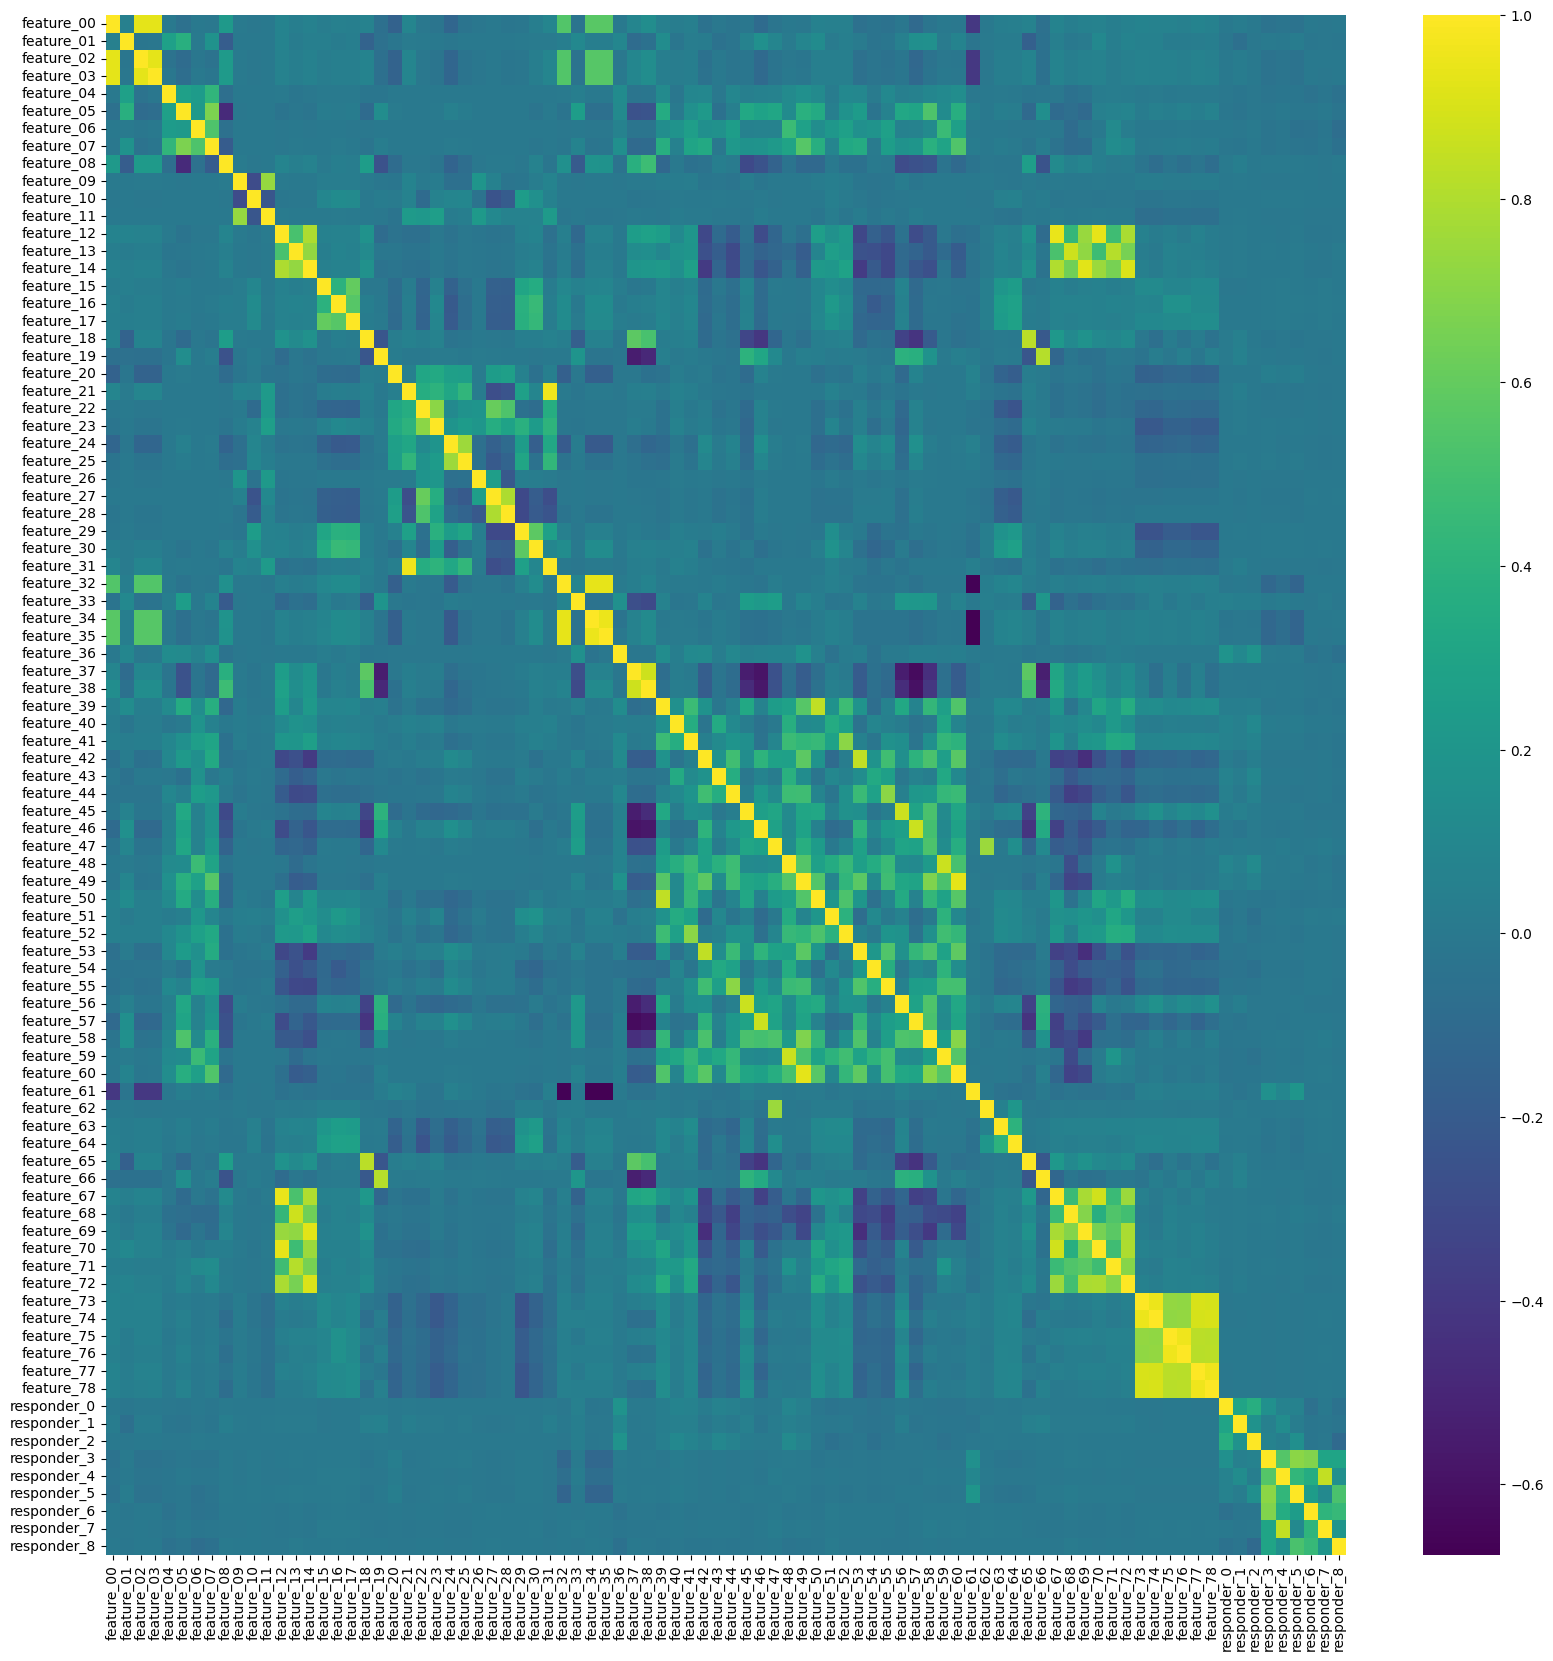

In [21]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

<Axes: >

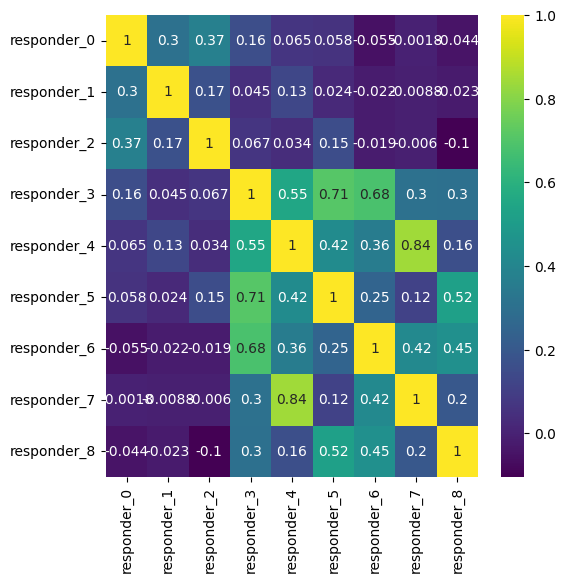

In [22]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [23]:
responders_tags = pl.read_csv(DATA_DIR / 'responders.csv')
responders_tags

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

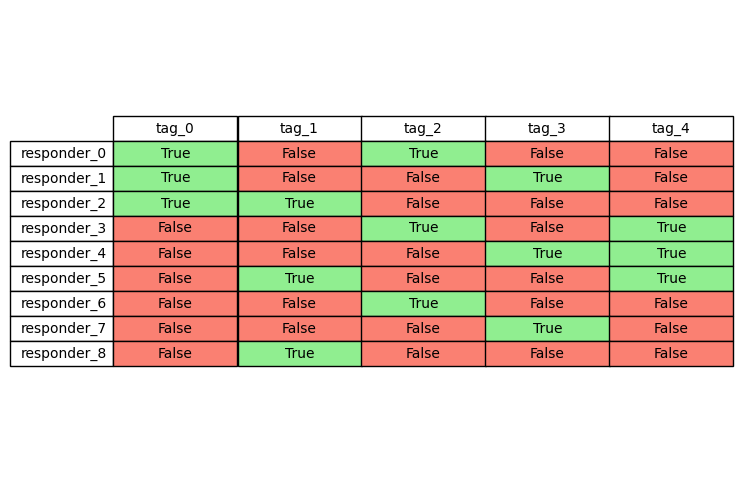

In [24]:
data = responders_tags.to_numpy()[:, 1:]

row_names = responders_tags['responder'].to_list()
col_names = responders_tags.columns[1:]

colors = np.where(data, "lightgreen", "salmon")

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("tight")
ax.axis("off")
cell_text = np.where(data, "True", "False")
table = ax.table(
    cellText=cell_text,
    cellColours=colors,
    rowLabels=row_names,
    colLabels=col_names,
    loc="center",
    cellLoc="center"
)
table.scale(1, 1.5)
plt.show()


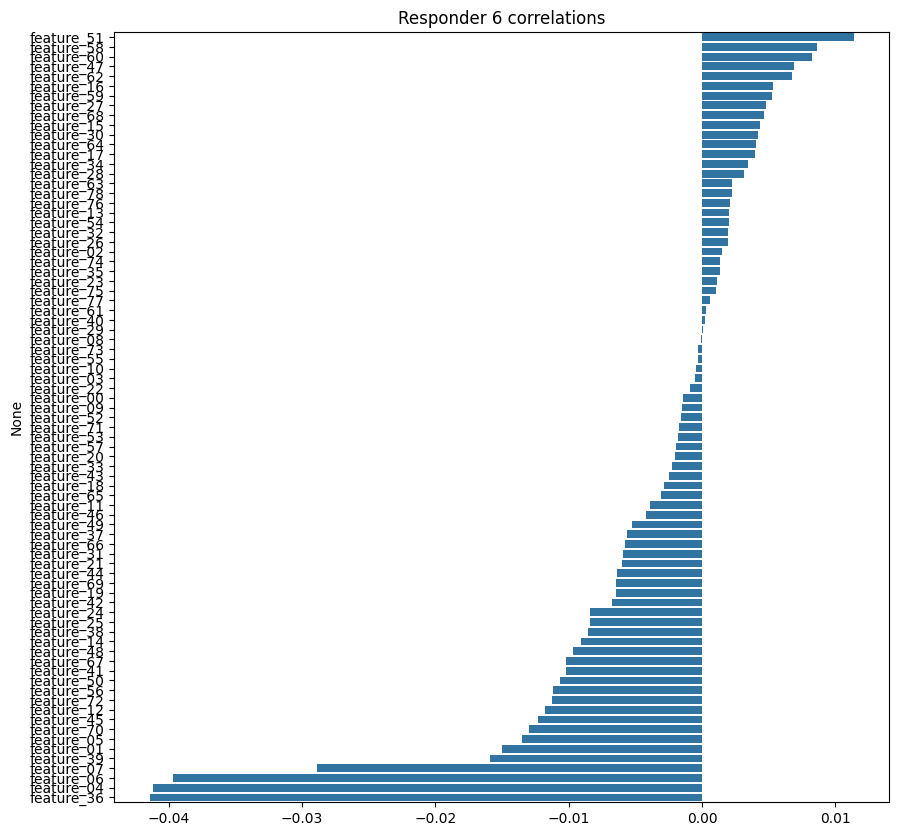

In [25]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

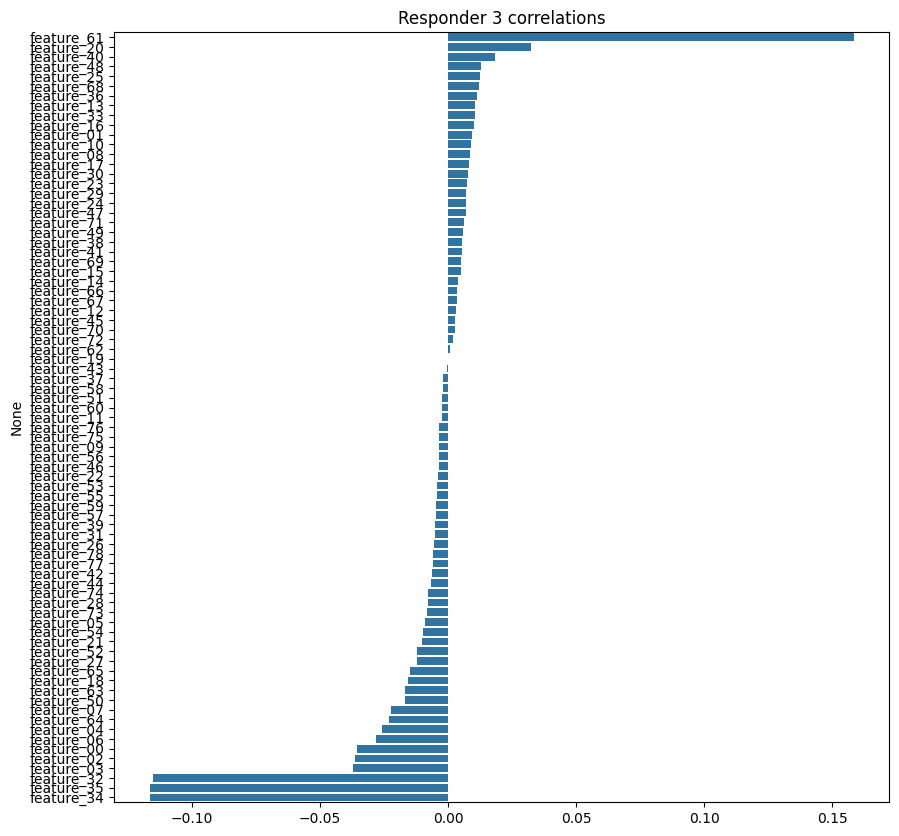

In [26]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [27]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [28]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)
stock_1_responders.head(3)

shape: (3, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1360    ┆ 0       ┆ 1         ┆ 0.351176   ┆ … ┆ -0.027899  ┆ -0.184599  ┆ -0.21643  ┆ -0.182844 │
│ 1360    ┆ 1       ┆ 1         ┆ 0.251616   ┆ … ┆ -0.089535  ┆ 0.432967   ┆ -0.290077 ┆ 0.152023  │
│ 1360    ┆ 2       ┆ 1         ┆ -0.184197  ┆ … ┆ 0.399584   ┆ 0.587663   ┆ -0.097162 ┆ 0.553339  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

<Axes: ylabel='Count'>

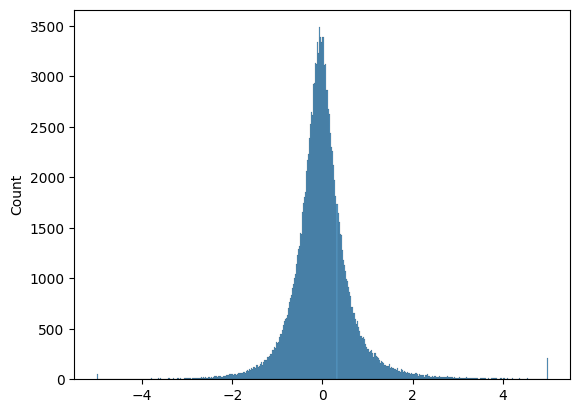

In [29]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

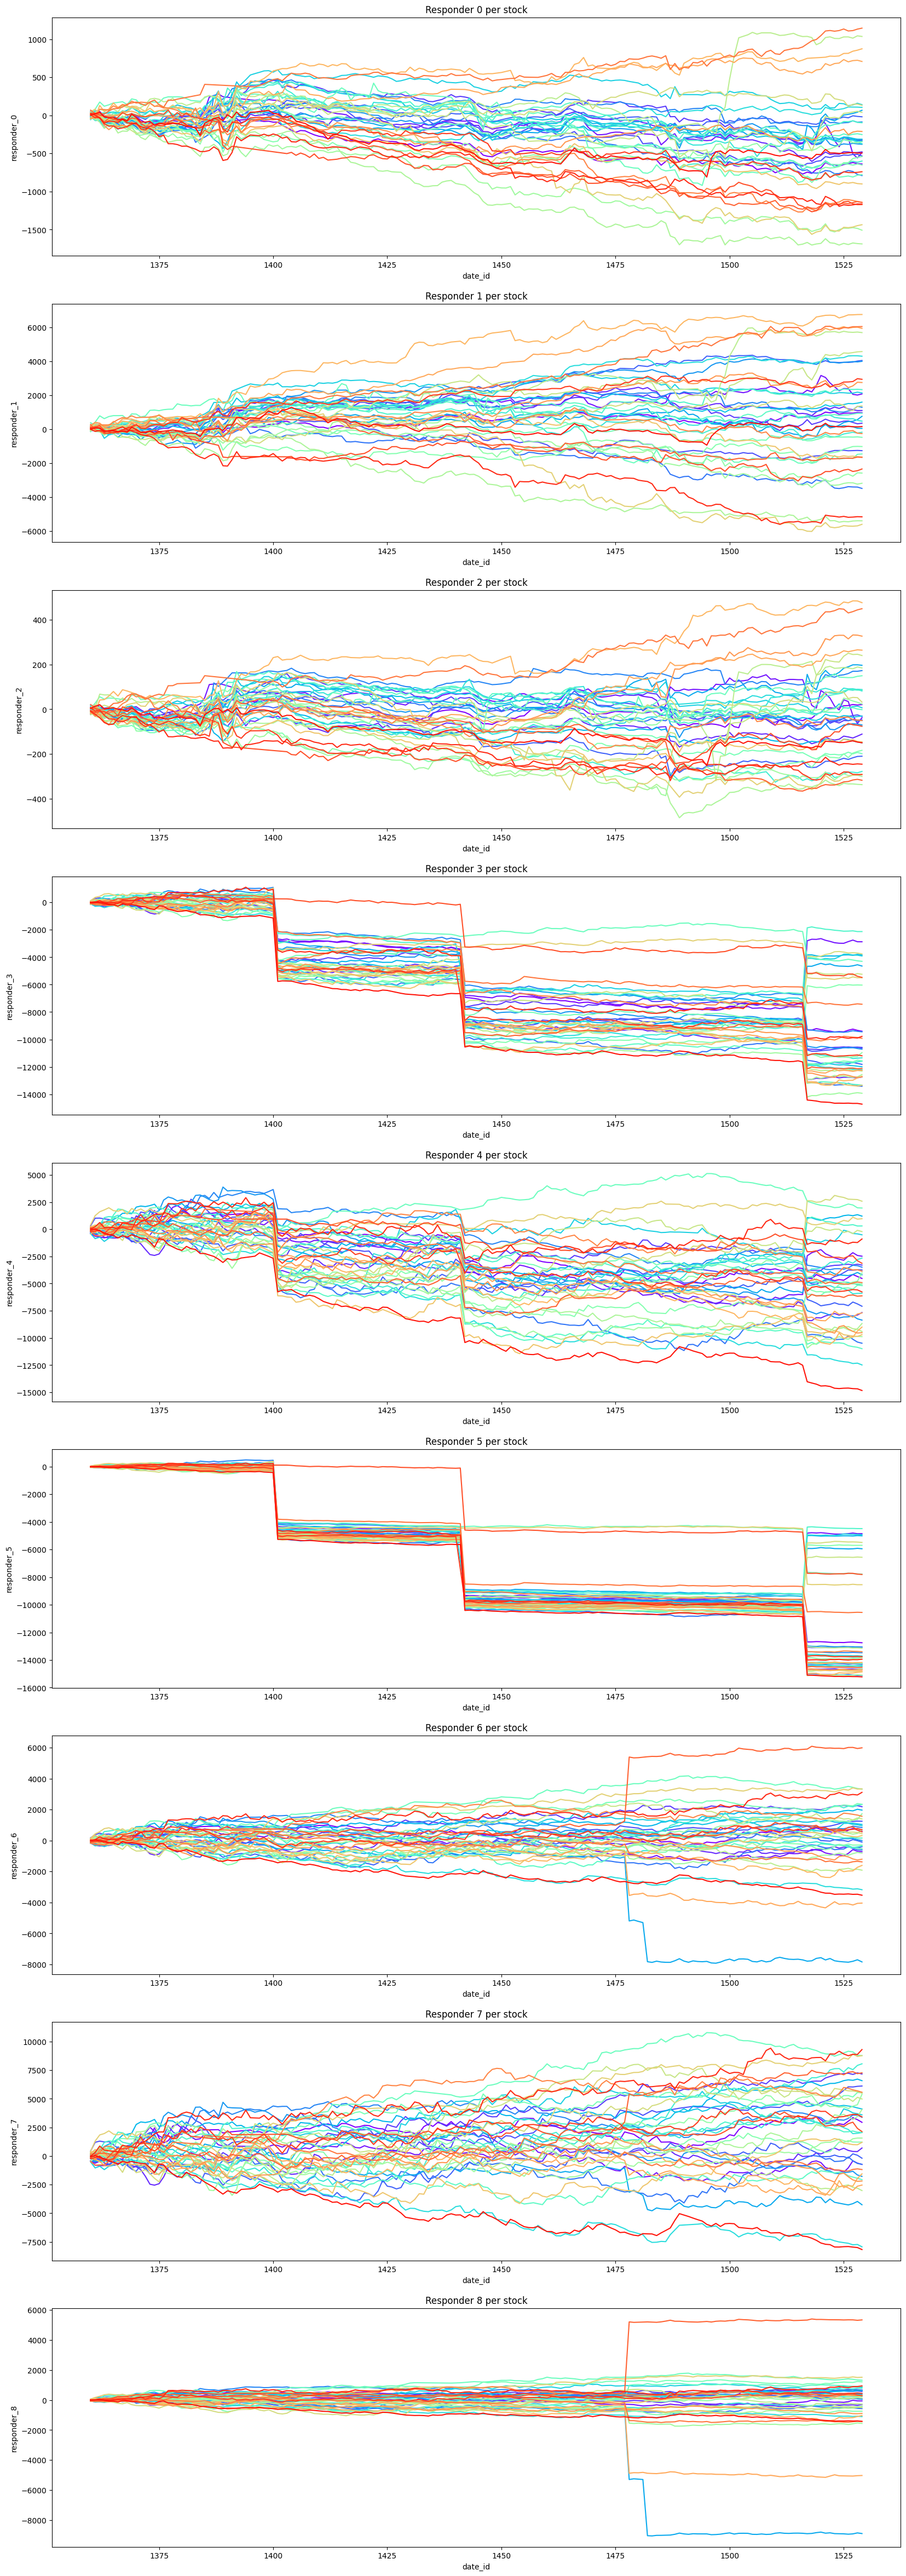

In [30]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [31]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1464    ┆ 327     ┆ -0.167259  ┆ 4.257171   ┆ … ┆ -0.645227  ┆ -1.132823 ┆ 3.407453  ┆ -4.114246 │
│ 1437    ┆ 83      ┆ -2.089919  ┆ -3.919788  ┆ … ┆ 1.736448   ┆ 1.130084  ┆ -5.821497 ┆ 5.756229  │
│ 1383    ┆ 927     ┆ -7.120437  ┆ 3.544508   ┆ … ┆ -7.243502  ┆ 3.163055  ┆ -3.92799  ┆ -11.77240 │
│         ┆         ┆            ┆            ┆   ┆            ┆           ┆           ┆ 8         │
│ 1455    ┆ 158     ┆ -1.481629  ┆ -2.547606  ┆ … ┆ -5.159903  ┆ -13.99271 ┆ -2.923614 ┆ -9.505371 │
│         ┆         ┆            ┆            ┆   ┆            ┆ 1         ┆           ┆           │
│ 1389    ┆ 801     ┆ -4.194493  ┆ -26.166897 ┆ … ┆ 2.623768   ┆ -1.681355 ┆ -17.44560 ┆ 3.355155  │
│         ┆         ┆            ┆            ┆   ┆            ┆           ┆ 4         ┆           │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

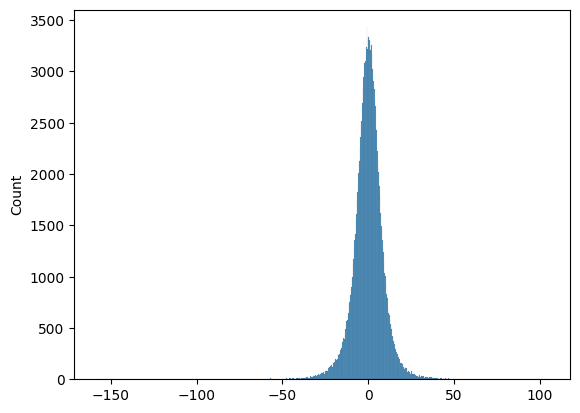

In [32]:
sns.histplot(time_responders['responder_6'].to_numpy())

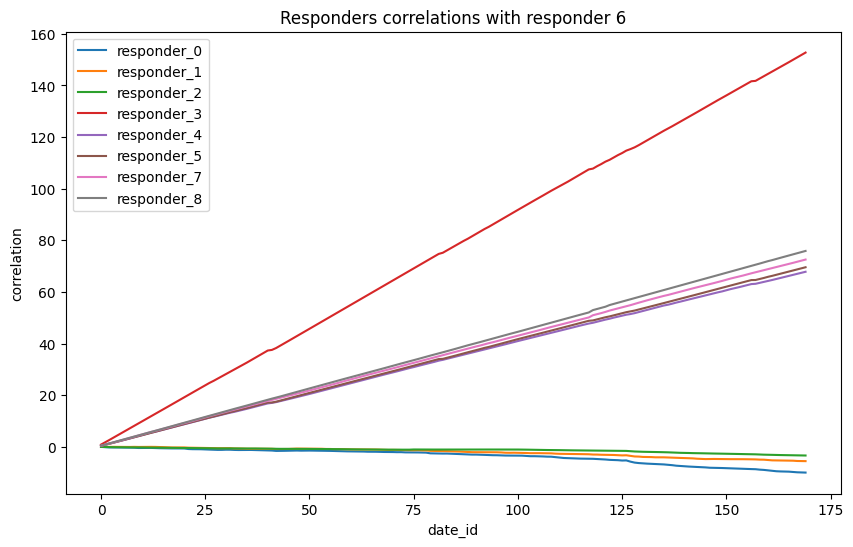

In [33]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [34]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])

agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.tail(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1529    ┆ 967     ┆ 34        ┆ 0.262104   ┆ … ┆ -0.472807  ┆ -0.514189  ┆ -0.171999 ┆ -0.909944 │
│ 1529    ┆ 967     ┆ 35        ┆ 1.510625   ┆ … ┆ 0.068478   ┆ -0.072836  ┆ -0.007559 ┆ -0.147855 │
│ 1529    ┆ 967     ┆ 36        ┆ 0.289079   ┆ … ┆ -0.204735  ┆ -0.132644  ┆ -0.02853  ┆ -0.232389 │
│ 1529    ┆ 967     ┆ 37        ┆ 0.410921   ┆ … ┆ -0.1678    ┆ -0.228638  ┆ -0.065763 ┆ -0.410197 │
│ 1529    ┆ 967     ┆ 38        ┆ 0.218008   ┆ … ┆ -0.208682  ┆ -0.210054  ┆ -0.067783 ┆ -0.344317 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

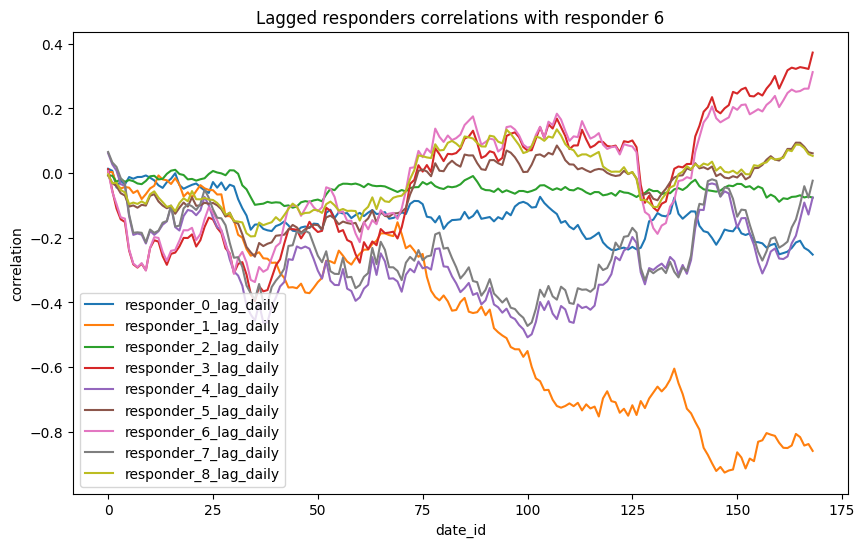

In [35]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

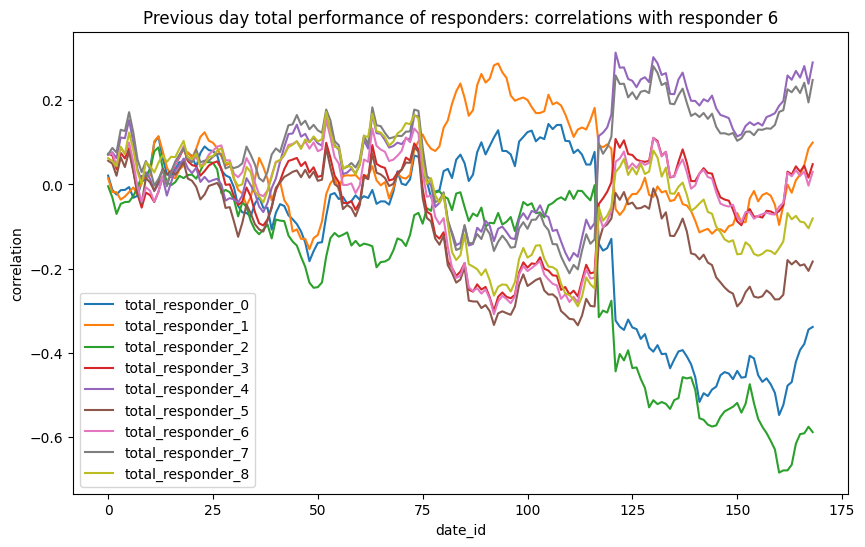

In [36]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

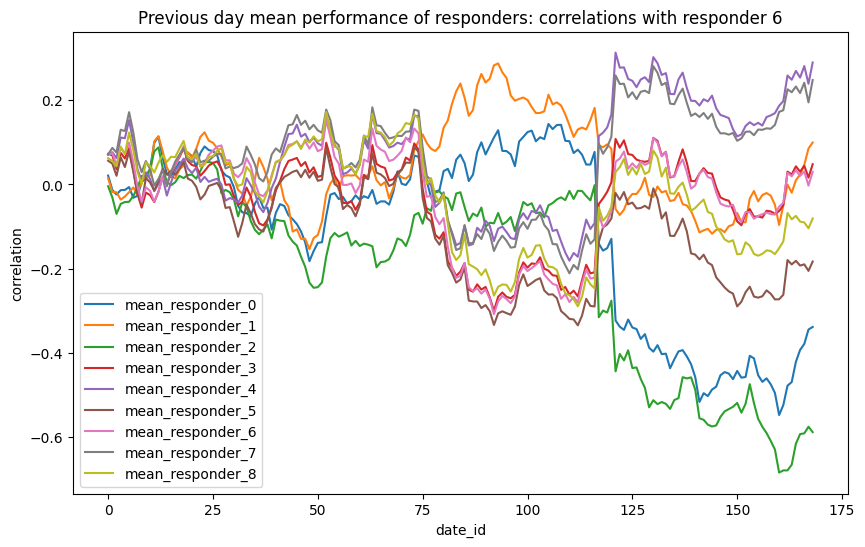

In [37]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [38]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1383    ┆ 3         ┆ -10.29306  ┆ -80.00180 ┆ … ┆ 0.0037    ┆ -0.01829  ┆ -0.092948 ┆ -0.002201 │
│         ┆           ┆            ┆ 8         ┆   ┆           ┆           ┆           ┆           │
│ 1454    ┆ 22        ┆ -109.50659 ┆ -474.3708 ┆ … ┆ -0.000834 ┆ -0.022058 ┆ -0.092452 ┆ -0.007039 │
│         ┆           ┆ 9          ┆ 8         ┆   ┆           ┆           ┆           ┆           │
│ 1507    ┆ 4         ┆ 4.231196   ┆ -130.6257 ┆ … ┆ -0.00071  ┆ -0.025966 ┆ -0.078796 ┆ -0.010399 │
│         ┆           ┆            ┆ 78        ┆   ┆           ┆           ┆           ┆           │
│ 1444    ┆ 38        ┆ -14.22017  ┆ 0.960298  ┆ … ┆ -0.00207  ┆ 0.007099  ┆ 0.012388  ┆ 0.002109  │
│ 1402    ┆ 20        ┆ 10.136609  ┆ -23.12537 ┆ … ┆ -0.72036  ┆ -0.030137 ┆ -0.037334 ┆ -0.014184 │
│         ┆           ┆            ┆ 4         ┆   ┆           ┆           ┆           ┆           │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

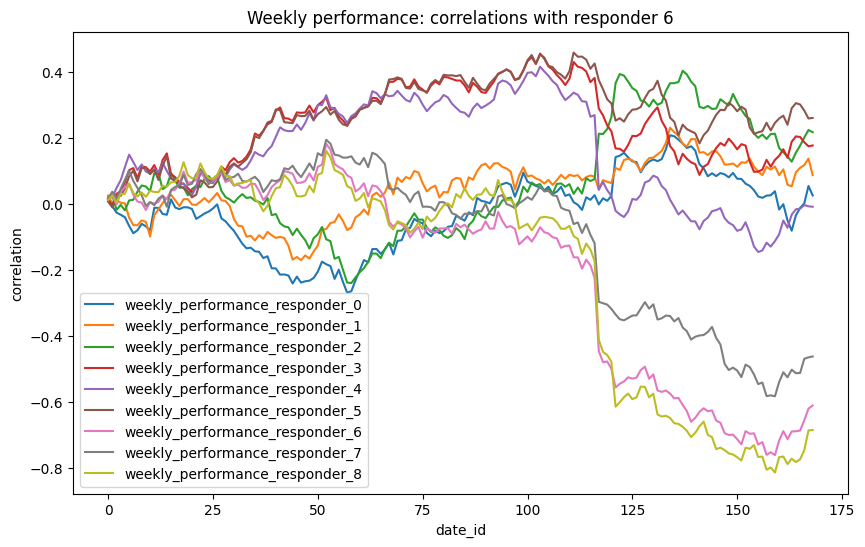

In [39]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

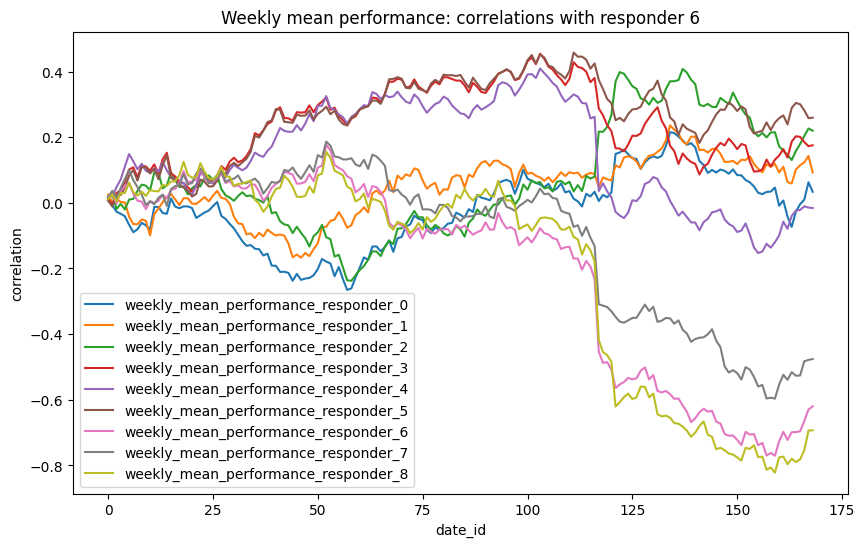

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [41]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1361    ┆ 0       ┆ 0         ┆ -0.561206  ┆ … ┆ -1.620408  ┆ 0.374767   ┆ -1.049378 ┆ -2.496996 │
│ 1361    ┆ 0       ┆ 1         ┆ -0.385569  ┆ … ┆ -0.027899  ┆ -0.184599  ┆ -0.21643  ┆ -0.182844 │
│ 1361    ┆ 0       ┆ 2         ┆ -0.038064  ┆ … ┆ 0.363652   ┆ 0.236567   ┆ -1.445096 ┆ 0.506134  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [42]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1361    ┆ -0.013334  ┆ -0.003021 ┆ 0.00666   ┆ … ┆ -0.05589  ┆ 0.069711  ┆ 0.070872  ┆ -0.06201  │
│ 1362    ┆ 0.006388   ┆ -0.000123 ┆ 0.001894  ┆ … ┆ 0.006835  ┆ 0.00413   ┆ 0.015312  ┆ 0.006917  │
│ 1363    ┆ 0.05194    ┆ 0.036933  ┆ 0.019086  ┆ … ┆ 0.0289    ┆ -0.029397 ┆ -0.010747 ┆ 0.012619  │
│ 1364    ┆ -0.021285  ┆ 0.013992  ┆ -0.010031 ┆ … ┆ -0.043846 ┆ 0.042577  ┆ 0.053915  ┆ -0.046708 │
│ 1365    ┆ 0.011772   ┆ -0.004753 ┆ 0.009574  ┆ … ┆ 0.023103  ┆ -0.015254 ┆ -0.003153 ┆ 0.017616  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1525    ┆ -0.017074  ┆ -0.03576  ┆ -0.001014 ┆ … ┆ -0.008568 ┆ 0.01439   ┆ 0.013566  ┆ -0.008182 │
│ 1526    ┆ -0.005456  ┆ 0.009801  ┆ -0.004044 ┆ … ┆ 0.011287  ┆ -0.013539 ┆ -0.015477 ┆ 0.013582  │
│ 1527    ┆ 0.022053   ┆ 0.02614   ┆ 0.006776  ┆ … ┆ -0.002935 ┆ 0.010555  ┆ 0.024361  ┆ 0.002005  │
│ 1528    ┆ 0.007874   ┆ -0.004712 ┆ -0.003281 ┆ … ┆ 0.015586  ┆ -0.033576 ┆ -0.046645 ┆ 0.01396   │
│ 1529    ┆ 0.013072   ┆ 0.021276  ┆ 0.003909  ┆ … ┆ -0.022268 ┆ 0.032721  ┆ 0.053156  ┆ -0.023357 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [43]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_1_lag_daily  0.005089  0.023627  0.215372     -0.219473  0.000085
mean_responder_2       0.003480  0.036062  0.096487     -0.243410  0.006397
total_responder_2      0.003480  0.036062  0.096487     -0.243410  0.006397
responder_3_lag_daily  0.002206  0.032149  0.068628     -0.407996  0.002922
total_responder_0      0.002003  0.033539  0.059719     -0.325582  0.005361
mean_responder_0       0.002003  0.033539  0.059719     -0.325582  0.005361
responder_6_lag_daily  0.001849  0.032940  0.056119     -0.371942  0.001114
mean_responder_4       0.001710  0.034402  0.049712     -0.347944  0.006820
total_responder_4      0.001710  0.034402  0.049712     -0.347944  0.006820
responder_0_lag_daily  0.001493  0.017956  0.083165     -0.162178  0.000457
total_responder_7      0.001463  0.034967  0.041850     -0.393913  0.006601
mean_responder_7       0.001463  0.034967  0.041850     -0.393913  0.006601
mean_responder_5       0.001085  0.030902  0.035097     -0.324891  0.003367
total_responder_5      0.001085  0.030902  0.035097     -0.324891  0.003367
total_responder_1      0.000585  0.027975  0.020925     -0.403973  0.004054
mean_responder_1       0.000585  0.027975  0.020925     -0.403973  0.004054
total_responder_8      0.000480  0.032384  0.014830     -0.369654  0.003301
mean_responder_8       0.000480  0.032384  0.014830     -0.369654  0.003301
responder_2_lag_daily  0.000451  0.009054  0.049782     -0.098020  0.000085
responder_4_lag_daily  0.000448  0.036204  0.012373     -0.476230  0.007188
responder_5_lag_daily  0.000361  0.017622  0.020507     -0.251296  0.000086
responder_8_lag_daily  0.000314  0.017909  0.017528     -0.240468  0.001538
mean_responder_3       0.000281  0.031657  0.008890     -0.398692  0.005706
total_responder_3      0.000281  0.031657  0.008890     -0.398692  0.005706
mean_responder_6       0.000175  0.031584  0.005536     -0.460704  0.005608
total_responder_6      0.000175  0.031584  0.005536     -0.460704  0.005608
responder_7_lag_daily  0.000140  0.036012  0.003887     -0.453956  0.006618

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

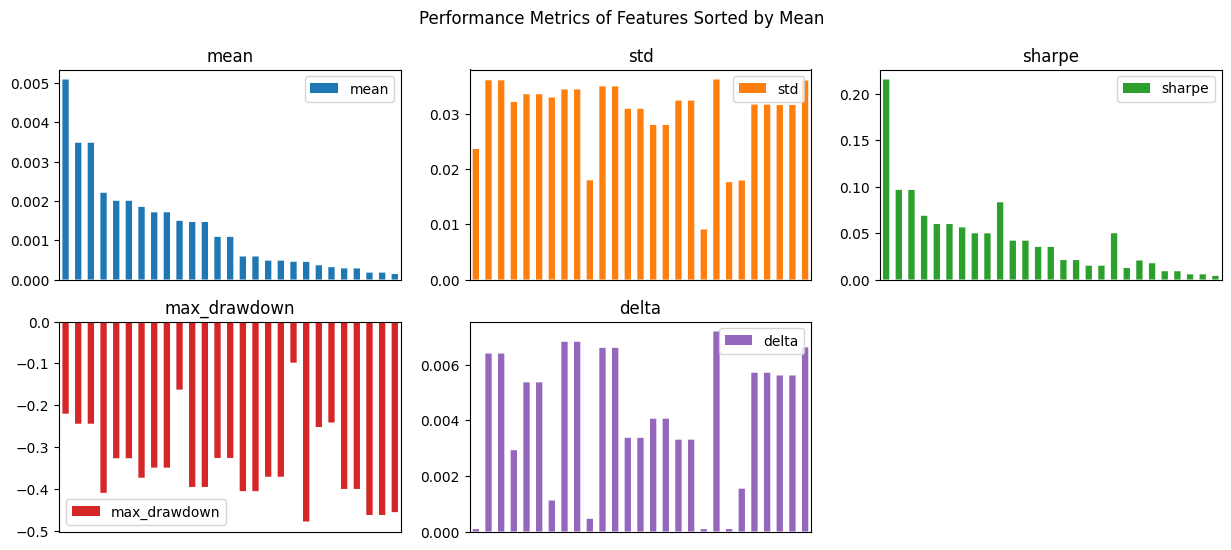

In [44]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

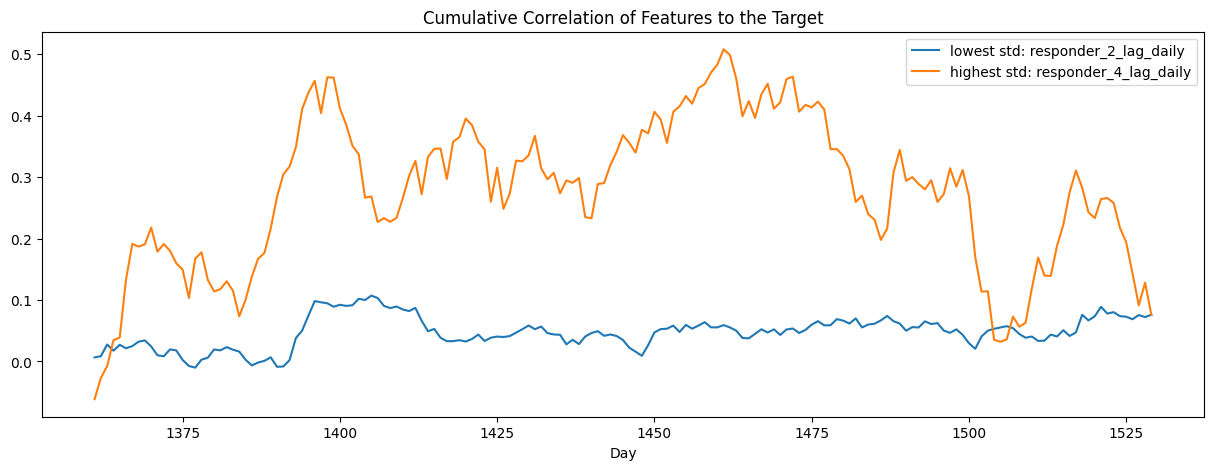

In [45]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

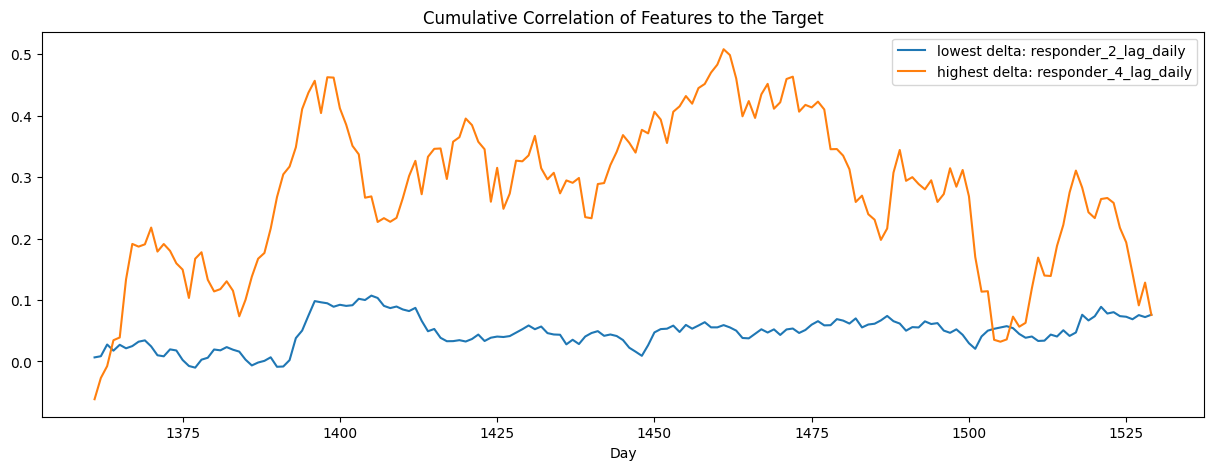

In [46]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

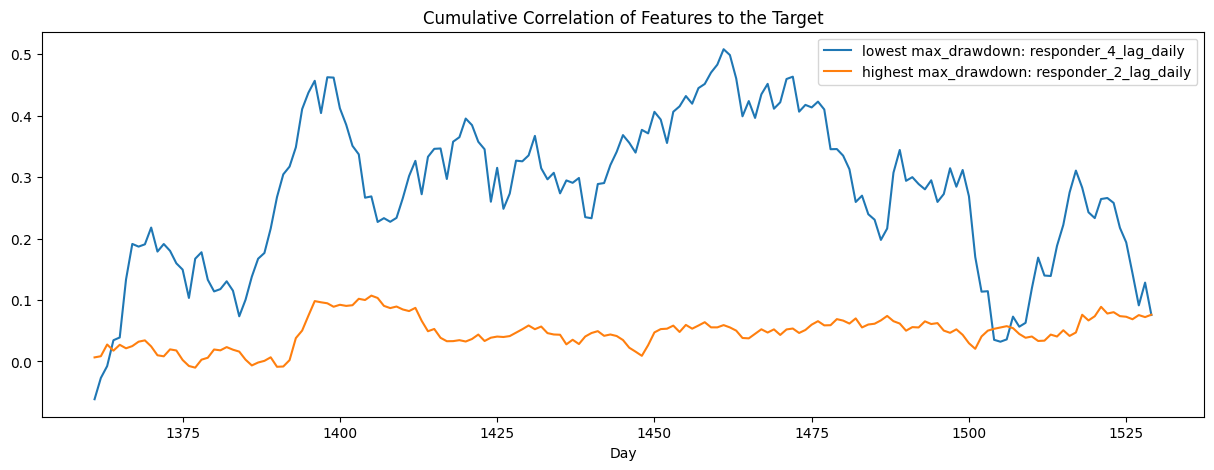

In [47]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])